In [1]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(RColorBrewer)
library(pheatmap)
library(umap)
library(cowplot)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
gyn_projects <- c("CESC", "UCS", "UCEC", "OV")
# nongyn_projects <- c("TCGA-BRCA", "TCGA-COAD", "TCGA-LGG")
nongyn_projects <- c("BRCA", "COAD", "TGCT", "PRAD")
pan_projects <- c(gyn_projects, nongyn_projects)

# Load data

In [4]:
pan_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_pan_coldata.tsv")) %>%
    dplyr::mutate(project_short = substring(project, 6)) %>%
    dplyr::select(-project) %>%
    dplyr::rename(project = project_short)
pan_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_pan_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)

Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.


In [5]:
gyn_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_gyn_coldata.tsv")) %>%
    dplyr::mutate(project_short = substring(project, 6)) %>%
    dplyr::select(-project) %>%
    dplyr::rename(project = project_short)
gyn_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_gyn_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)

Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
See spec(...) for full column specifications.


In [6]:
get_pca_results <- function(counts, coldata_df) {
    pca_res <- prcomp(t(counts), center = TRUE, scale. = FALSE)
    
    pca_res_df <- pca_res$x %>%
        as_tibble(rownames = "sample_name") %>%
        mutate(project = coldata_df$project) %>%
        dplyr::select(sample_name, project, everything())
    
    pca_var_df <- tibble(pc = colnames(pca_res$x)) %>%
        mutate(var = pca_res$sdev ^ 2) %>%
        mutate(pct_var = round(var / sum(var) * 100, 1)) %>%
        mutate(pc_fact = factor(colnames(pca_res$x), levels = colnames(pca_res$x)))
    
    return(list(
        res = pca_res_df,
        var = pca_var_df
    ))
}

get_umap_results <- function(counts, coldata_df, random_state) {
    res_umap <- umap(t(counts), random_state = random_state)
    
    colnames(res_umap$layout) <- c("x1", "x2")
    umap_df <- res_umap$layout %>%
        as_tibble() %>%
        bind_cols(coldata_df)
    return(umap_df)
}

pca_scatter <- function(df, pc_x, pc_y, pc_x_pctvar, pc_y_pctvar, col, legend_title, breaks = FALSE, values = FALSE, size = 0.5, legend_color_size = 6, tick_size = 10, axlb_size = 12, hide_legend = FALSE) {
    plt <- ggplot(df) +
        aes_string(x = pc_x, y = pc_y, color = col) +
        geom_point(size = size) +
        {if(breaks != FALSE && values != FALSE) scale_color_manual(breaks = breaks, values = values) } +
        guides(color = guide_legend(title = legend_title, override.aes = list(size = legend_color_size))) +
        theme_classic() +
        theme(
            legend.key = element_rect(fill = NA, color = NA),
            legend.title = element_text(size = 24, face = "bold"),
            legend.text = element_text(size = 18),
            axis.text.x = element_text(size = tick_size),
            axis.text.y = element_text(size = tick_size),
            axis.title.x = element_text(size = axlb_size),
            axis.title.y = element_text(size = axlb_size)            
        ) +
        xlab(paste0(pc_x, " (", pc_x_pctvar, "%)")) + 
        ylab(paste0(pc_y, " (", pc_y_pctvar, "%)")) +
        {if(hide_legend) theme(legend.position = "none")} +
        coord_fixed()
    return(plt)
}

umap_scatter <- function(df, umap_x, umap_y, col, legend_title, breaks = FALSE, values = FALSE, hide_legend = FALSE, pt_size = 0.5, legend_color_size = 6, tick_size = 10, axlb_size = 12, jitter_w = 0.1, jitter_h = 0.1, seed = 123) {
    plt <- ggplot(df) +
        aes_string(x = umap_x, y = umap_y, color = col) +
        geom_point(size = pt_size, position = position_jitter(w = jitter_w, h = jitter_h, seed = seed)) +
        {if(breaks != FALSE && values != FALSE) scale_color_manual(breaks = breaks, values = values) } +
        guides(color = guide_legend(title = legend_title, override.aes = list(size = legend_color_size))) +
        theme_classic() +
        theme(
            legend.key = element_rect(fill = NA, color = NA),
            legend.title = element_text(size = 18, face = "bold"),
            legend.text = element_text(size = 18),
            axis.text.x = element_text(size = tick_size),
            axis.text.y = element_text(size = tick_size),
            axis.title.x = element_text(size = axlb_size),
            axis.title.y = element_text(size = axlb_size)
        ) +
        {if(hide_legend) theme(legend.position = "none")}
#         coord_fixed()
    return(plt)
}

plot_hm <- function(hm, dest) {
    png(dest)
    grid::grid.newpage()
    grid::grid.draw(hm$gtable)
    dev.off()
}

# Heatmaps

## Get representative group samples

In [7]:
gyn_centroids <- get_group_centroids(
    gyn_counts_df, gyn_coldata_df, gyn_projects, "project", "sample_name"
)

pan_centroids <- get_group_centroids(
    pan_counts_df, pan_coldata_df, pan_projects, "project", "sample_name"
)

In [8]:
gyn_hm_meta_df <- balanced_group_sample(
    gyn_counts_df,
    gyn_coldata_df,
    gyn_centroids,
    gyn_projects,
    n = 10,
    "project",
    "sample_name"
)

pan_hm_meta_df <- balanced_group_sample(
    pan_counts_df,
    pan_coldata_df,
    pan_centroids,
    pan_projects,
    n = 10,
    "project",
    "sample_name"
)

# Get data needed for heatmaps

In [9]:
gyn_hm_ls <- get_hm_dfs(gyn_counts_df, gyn_coldata_df, gyn_hm_meta_df)
# gyn_hm_ls$coldata <- dplyr::rename(gyn_hm_ls$coldata, Project = project)
gyn_hm_ls$coldata <- dplyr::rename(gyn_hm_ls$coldata, "Cancer Type" = "project")

pan_hm_ls <- get_hm_dfs(pan_counts_df, pan_coldata_df, pan_hm_meta_df)
pan_hm_ls$coldata <- dplyr::rename(pan_hm_ls$coldata, "Cancer Type" = "project")

In [10]:
gyn_clusts <- get_hm_clusters(gyn_hm_ls$counts)
gyn_zscores <- t(apply(gyn_hm_ls$counts, 1, rutils::get_z_score))

pan_clusts <- get_hm_clusters(pan_hm_ls$counts)
pan_zscores <- t(apply(pan_hm_ls$counts, 1, rutils::get_z_score))

In [11]:
# Set color orders
gyn_color_names = levels(factor(unique(gyn_hm_ls$coldata[["Cancer Type"]]), levels = gyn_projects))
pan_color_names = levels(factor(unique(pan_hm_ls$coldata["Cancer Type"]), levels = c(gyn_projects, nongyn_projects)))

gyn_proj_colors <- list("Cancer Type" = brewer.pal(n = length(gyn_projects), name = "Set2"))
names(gyn_proj_colors[["Cancer Type"]]) <- gyn_color_names

pan_proj_colors <- list("Cancer Type" = brewer.pal(n = length(pan_projects), name = "Set2"))
names(pan_proj_colors[["Cancer Type"]]) <- pan_color_names

In [12]:
pan_proj_colors

$`Cancer Type`
     CESC       UCS      UCEC        OV      BRCA      COAD      TGCT      PRAD 
"#66C2A5" "#FC8D62" "#8DA0CB" "#E78AC3" "#A6D854" "#FFD92F" "#E5C494" "#B3B3B3"

png 
  2

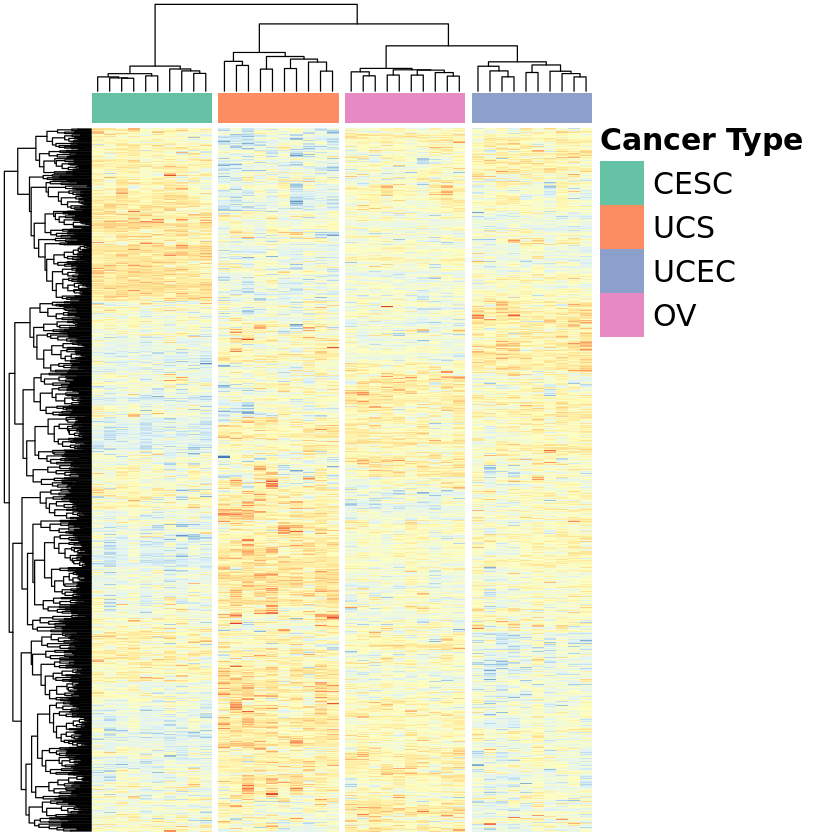

png 
  2

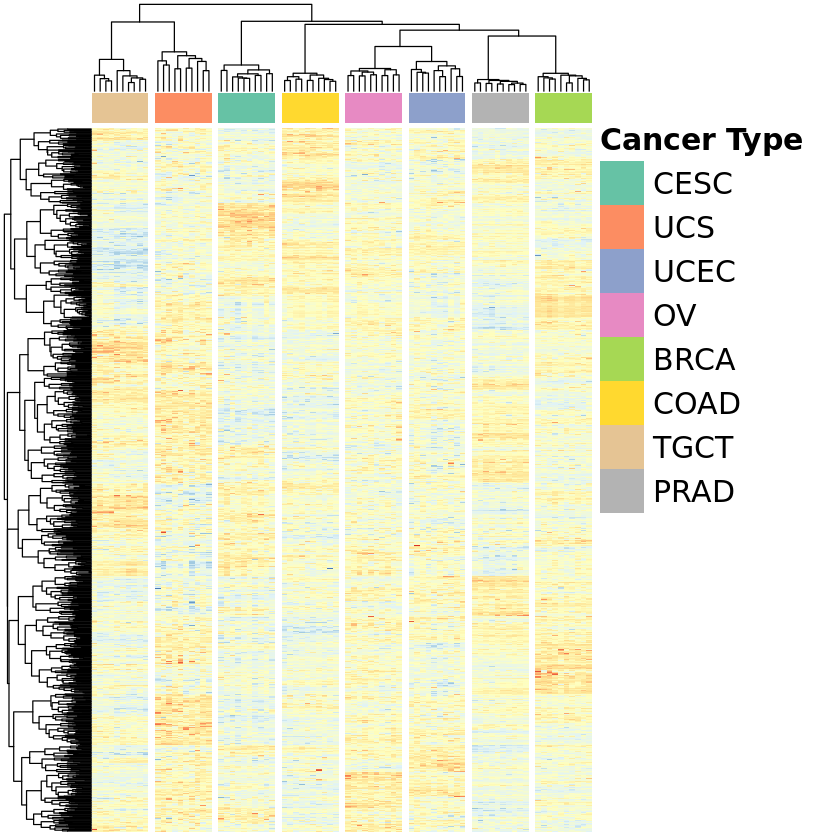

In [35]:
gyn_hm <- pheatmap(
    gyn_zscores,
    cluster_rows = gyn_clusts$row,
    cluster_cols = gyn_clusts$col,
    cutree_cols = length(gyn_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = gyn_hm_ls$coldata["Cancer Type"],
    annotation_names_col = FALSE,
    annotation_colors = gyn_proj_colors,
    fontsize = 18,
    legend = FALSE,
)
plot_hm(gyn_hm, paste0(dirs$figures_dir, "/gyn_heatmap.png"))

pan_hm <- pheatmap(
    pan_zscores,
    cluster_rows = pan_clusts$row,
    cluster_cols = pan_clusts$col,
    cutree_cols = length(pan_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = pan_hm_ls$coldata["Cancer Type"],
    annotation_names_col = FALSE,
    annotation_colors = pan_proj_colors,
    fontsize = 18,
    legend = FALSE
)
plot_hm(pan_hm, paste0(dirs$figures_dir, "/pan_heatmap.png"))

# PCA

In [14]:
pan_pca_ls <- get_pca_results(pan_counts_df[, -1], pan_coldata_df)
gyn_pca_ls <- get_pca_results(gyn_counts_df[, -1], gyn_coldata_df)

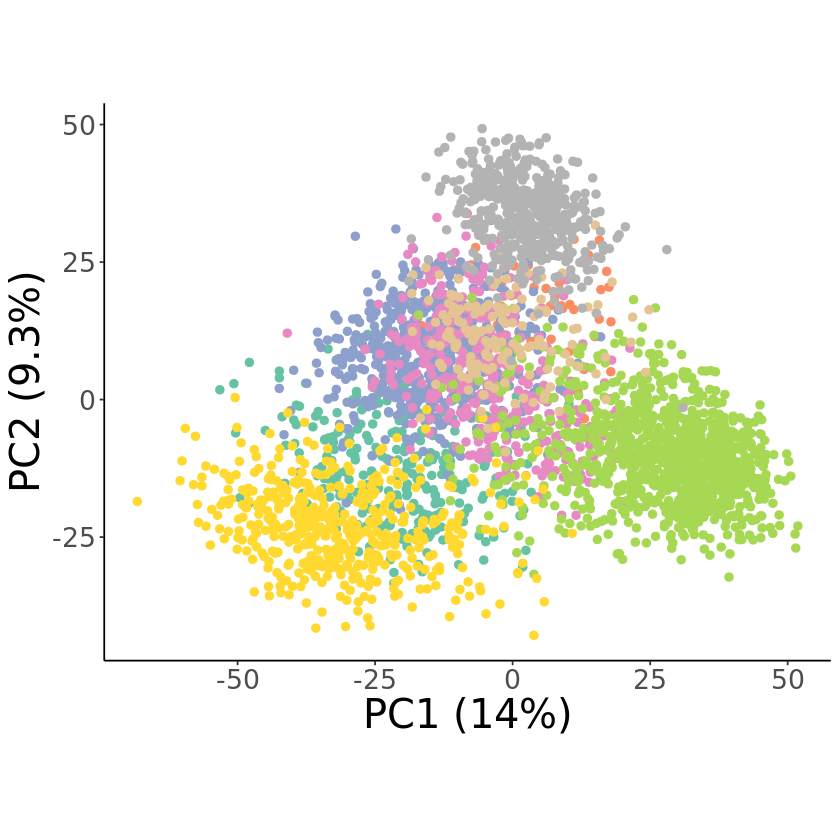

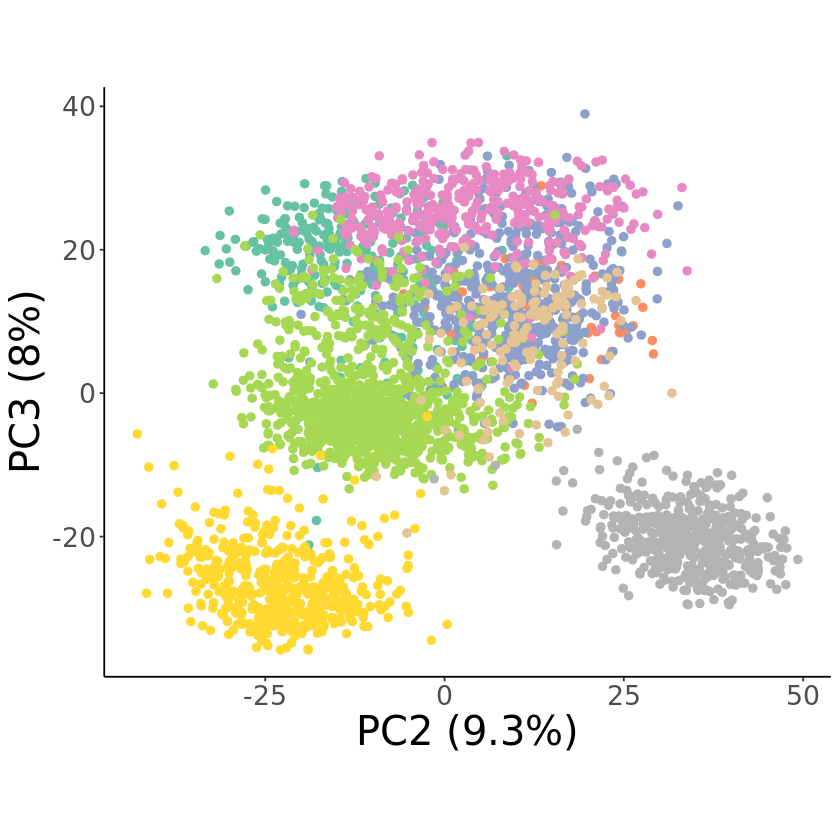

In [15]:
pca_scatter(
    pan_pca_ls$res, "PC1", "PC2", pan_pca_ls$var[1, ]$pct_var, pan_pca_ls$var[2, ]$pct_var,
    "project", legend_title = "Cancer Type", tick_size = 16, axlb_size = 24, size = 2,
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    hide_legend = TRUE
)
ggsave(filename = paste0(dirs$figures_dir, "/pan_PC2_vs_PC1.png"), last_plot(), height = 6, width = 12)
pca_scatter(
    pan_pca_ls$res, "PC2", "PC3", pan_pca_ls$var[2, ]$pct_var, pan_pca_ls$var[3, ]$pct_var, "project",
    legend_title = "Cancer Type", tick_size = 16, axlb_size = 24, size = 2,
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    hide_legend = TRUE
)
ggsave(filename = paste0(dirs$figures_dir, "/pan_PC3_vs_PC2.png"), last_plot(), height = 6, width = 12)

# pca_scatter(gyn_pca_ls$res, "PC1", "PC2", gyn_pca_ls$var[1, ]$pct_var, gyn_pca_ls$var[2, ]$pct_var, "project", legend_title = "Cancer Type")
# ggsave(filename = paste0(dirs$figures_dir, "/gyn_PC2_vs_PC1.png"), last_plot())
# pca_scatter(gyn_pca_ls$res, "PC2", "PC3", gyn_pca_ls$var[2, ]$pct_var, gyn_pca_ls$var[3, ]$pct_var, "project", legend_title = "Cancer Type")
# ggsave(filename = paste0(dirs$figures_dir, "/gyn_PC3_vs_PC2.png"), last_plot())

In [16]:
pan_pca_pivot_df <- pan_pca_ls$res %>%
    dplyr::select(sample_name, PC1:PC4, project) %>%
    pivot_longer(cols = PC1:PC4, names_to = "PC", values_to = "loadings") %>%
    mutate(proj_id = as.numeric(as.factor(project)))

head(pan_pca_pivot_df)

sample_name,project,PC,loadings,proj_id
<chr>,<chr>,<chr>,<dbl>,<dbl>
TCGA-MY-A5BF-01A-11R-A26T-07,CESC,PC1,-24.43918,2
TCGA-MY-A5BF-01A-11R-A26T-07,CESC,PC2,-15.01516,2
TCGA-MY-A5BF-01A-11R-A26T-07,CESC,PC3,25.48096,2
TCGA-MY-A5BF-01A-11R-A26T-07,CESC,PC4,-38.01402,2
TCGA-EA-A3HU-01A-11R-A213-07,CESC,PC1,-18.21484,2
TCGA-EA-A3HU-01A-11R-A213-07,CESC,PC2,-13.46796,2


Saving 6.67 x 6.67 in image


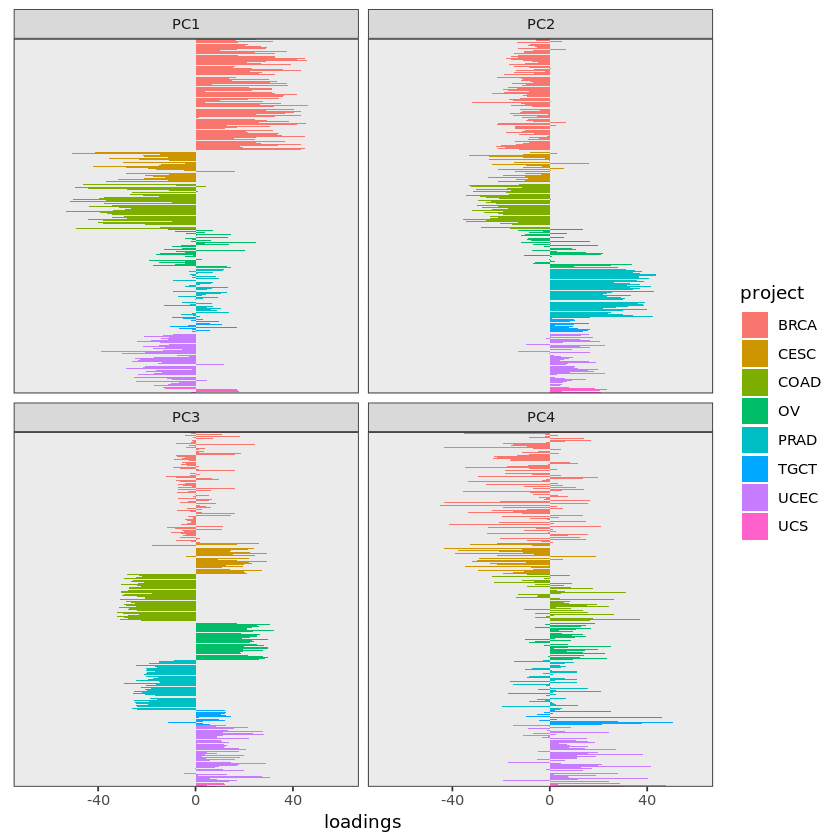

In [17]:
ggplot(pan_pca_pivot_df) +
    aes(x=reorder(sample_name, -proj_id), y=loadings, fill=project) +
    geom_bar(stat="identity") +
    facet_wrap(~PC) +
    coord_flip() +
    theme_bw() + 
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    )
ggsave(filename = paste0(dirs$figures_dir, "/all_gyn_small_multiples_plot.png"), last_plot())

# UMAP

In [18]:
pan_umap_df <- get_umap_results(pan_counts_df[, -1], pan_coldata_df, random_state = 123)
gyn_umap_df <- get_umap_results(gyn_counts_df[, -1], gyn_coldata_df, random_state = 123)

Saving 6.67 x 6.67 in image


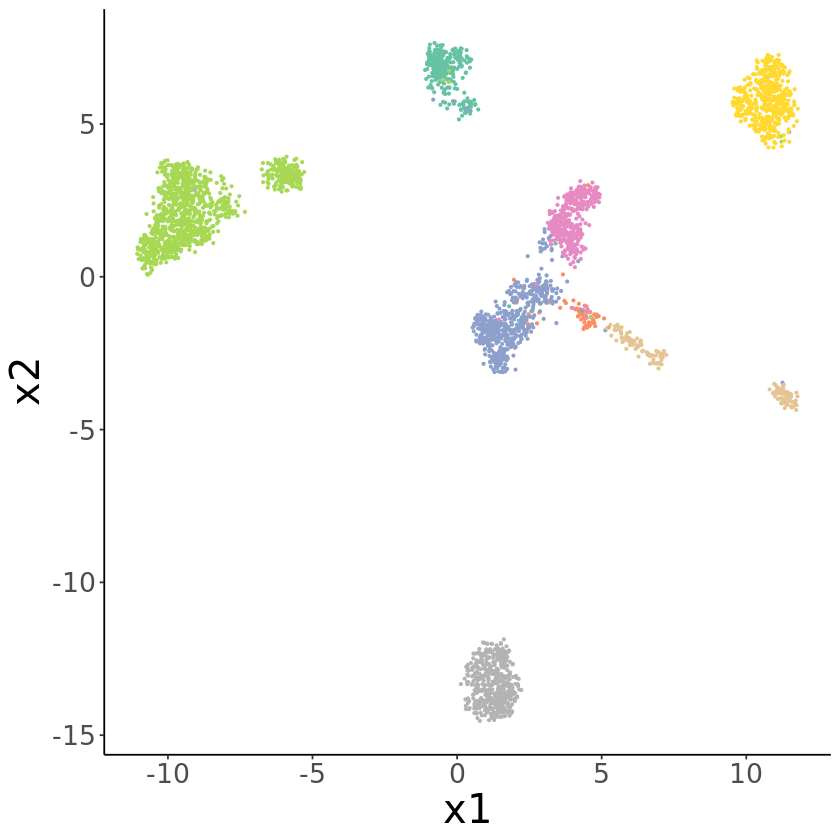

In [36]:
pan_umap_plt <- umap_scatter(
    pan_umap_df, "x1", "x2", "project",
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    pt_size = 0.5, jitter_h = 0.25, jitter_w = 0.25, seed = 123,
    tick_size = 16, axlb_size = 24,
    legend_title = "Cancer Type",
    hide_legend = TRUE
)
ggsave(filename = paste0(dirs$figures_dir, "/pan_umap.png"), last_plot())
pan_umap_plt

Saving 6.67 x 6.67 in image


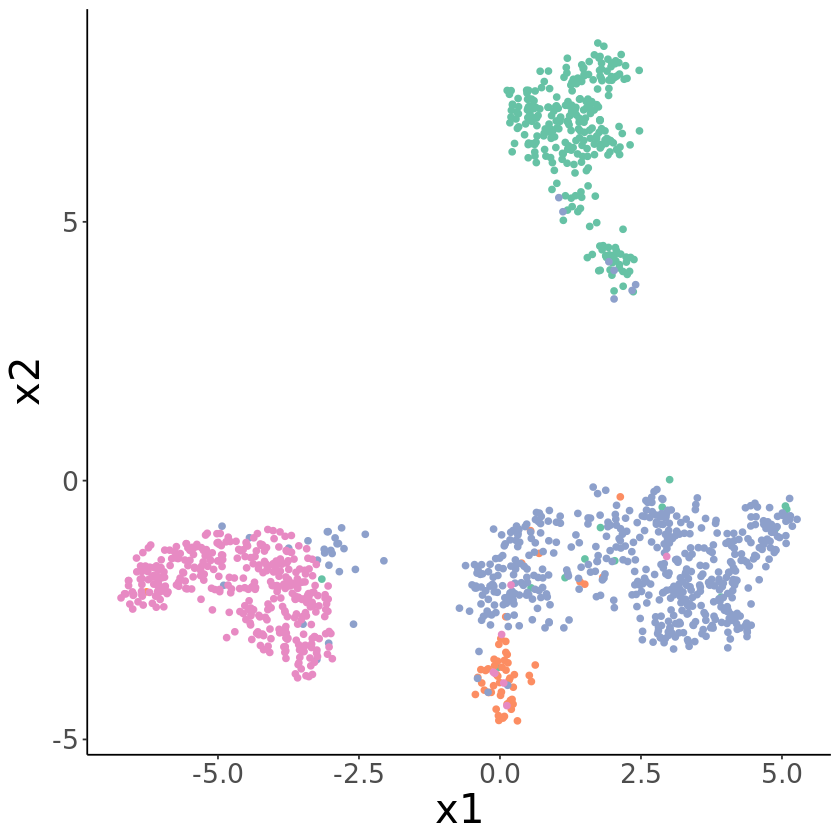

In [34]:
gyn_umap_plt <- umap_scatter(
    gyn_umap_df, "x1", "x2", "project", 
    breaks = names(pan_proj_colors[["Cancer Type"]]), values = as.character(pan_proj_colors[["Cancer Type"]]), 
    pt_size = 1.5, tick_size = 16, axlb_size = 24, jitter_h = 0.25, jitter_w = 0.25, seed = 3,
    hide_legend = TRUE, legend_title = "Cancer Type"
)
ggsave(filename = paste0(dirs$figures_dir, "/gyn_umap.png"), last_plot())
gyn_umap_plt